In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [ ]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.my_util import modis_loader, set_model
from ulmo.ssl.my_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [12]:
# Load options
opt_file = os.path.join(resource_filename('ulmo', 'runs'),
                        'SSL', 'First','experiments', 
                        'base_modis_model', 'opts.json')

In [13]:
opt = Params(opt_file)
opt = option_preprocess(opt)

In [47]:
model_path = './'
model_name = "last.pth"
model_path_title = os.path.join(model_path, model_name)

In [48]:
model_dict = torch.load(model_path_title)

In [50]:
model_dict.keys()

dict_keys(['opt', 'model', 'optimizer', 'epoch'])

In [30]:
modis_dataset_path = '../experiments/datasets/modis_dataset/MODIS_2010_95clear_128x128_inpaintT_preproc_0.8valid.h5'

In [32]:
with h5py.File(modis_dataset_path, 'r') as file:
    img = file['train'][:]

In [78]:
modis_data = np.repeat(img, 3, axis=1)

In [40]:
using_gpu = torch.cuda.is_available()

In [131]:
batch_size = opt.batch_size
num_samples = img.shape[0]
num_steps = num_samples // batch_size
remainder = num_samples % batch_size
latents_df = pd.DataFrame()

In [132]:
num_samples

134162

In [108]:
model, _ = set_model(opt)
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [133]:
with torch.no_grad():
    for i in trange(num_steps):
        image_batch = modis_data[i*batch_size: (i+1)*batch_size]
        image_tensor = torch.tensor(image_batch)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
        latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    if remainder:
        image_remainder = modis_data[-remainder:]
        image_tensor = torch.tensor(image_remainder)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
    latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    latents_numpy = latents_df.values

100%|██████████| 2096/2096 [06:53<00:00,  5.07it/s]


In [134]:
latents_numpy.shape

(134162, 128)

In [135]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_numpy)
### Transform the latents
latents_std = scaler.transform(latents_numpy)

In [136]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

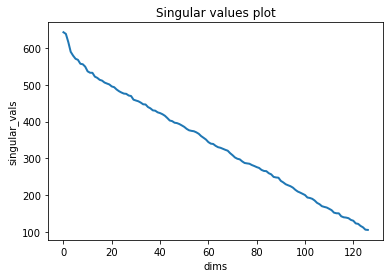

In [137]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [114]:
import umap

In [138]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 24min 47s, sys: 3min 2s, total: 27min 49s
Wall time: 13min 58s


In [116]:
import umap.plot

<AxesSubplot:>

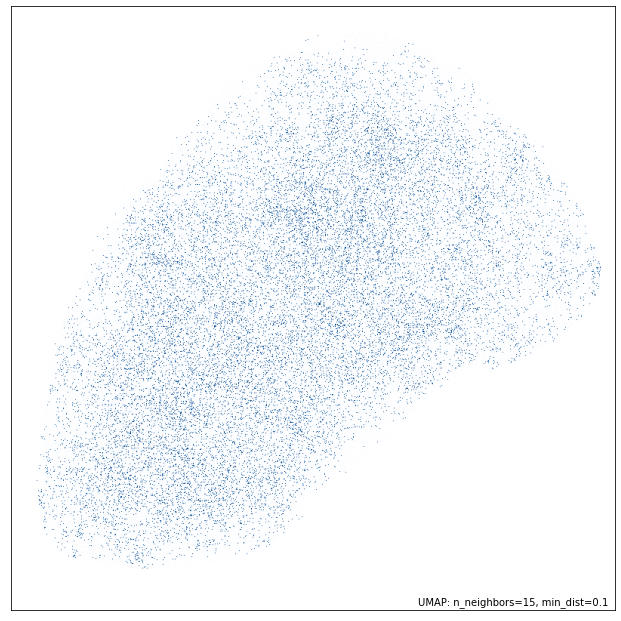

In [139]:
umap.plot.points(latents_mapping)

### Test the batch size of 1

In [140]:
batch_size = 32
num_samples = img.shape[0]
num_steps = num_samples // batch_size
remainder = num_samples % batch_size
latents_df = pd.DataFrame()

In [141]:
with torch.no_grad():
    for i in trange(num_steps):
        image_batch = modis_data[i*batch_size: (i+1)*batch_size]
        image_tensor = torch.tensor(image_batch)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
        latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    if remainder:
        image_remainder = modis_data[-remainder:]
        image_tensor = torch.tensor(image_remainder)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
        latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    latents_numpy = latents_df.values

100%|██████████| 4192/4192 [12:43<00:00,  5.49it/s]


In [142]:
latents_numpy.shape

(134162, 128)

In [143]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_numpy)
### Transform the latents
latents_std = scaler.transform(latents_numpy)

In [144]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

In [145]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 25min 26s, sys: 3min 3s, total: 28min 30s
Wall time: 14min 18s


<AxesSubplot:>

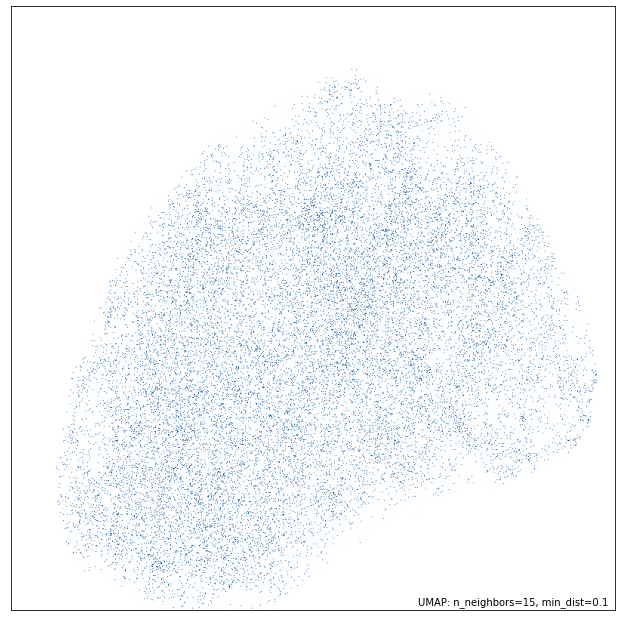

In [146]:
umap.plot.points(latents_mapping)

### Batchsize is 2

In [152]:
batch_size = 8
num_samples = img.shape[0]
num_steps = num_samples // batch_size
remainder = num_samples % batch_size
latents_df = pd.DataFrame()

In [153]:
with torch.no_grad():
    for i in trange(num_steps):
        image_batch = modis_data[i*batch_size: (i+1)*batch_size]
        image_tensor = torch.tensor(image_batch)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
        latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    if remainder:
        image_remainder = modis_data[-remainder:]
        image_tensor = torch.tensor(image_remainder)
        if using_gpu:
            latents_tensor = model(image_tensor.cuda())
            latents_numpy = latents_tensor.cpu().numpy()
        else:
            latents_tensor = model(image_tensor)
            latents_numpy = latents_tensor.numpy()
        latents_df = pd.concat([latents_df, pd.DataFrame(latents_numpy)], ignore_index=True)
    latents_numpy = latents_df.values

100%|██████████| 16770/16770 [49:38<00:00,  5.63it/s] 


In [154]:
latents_numpy.shape

(134162, 128)

In [155]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_numpy)
### Transform the latents
latents_std = scaler.transform(latents_numpy)

In [156]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

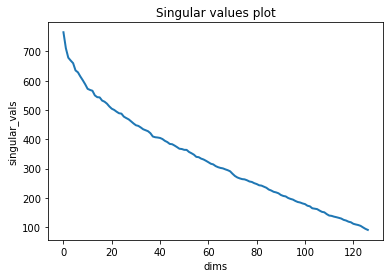

In [157]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [158]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 36min 23s, sys: 3min 3s, total: 39min 27s
Wall time: 19min 54s


<AxesSubplot:>

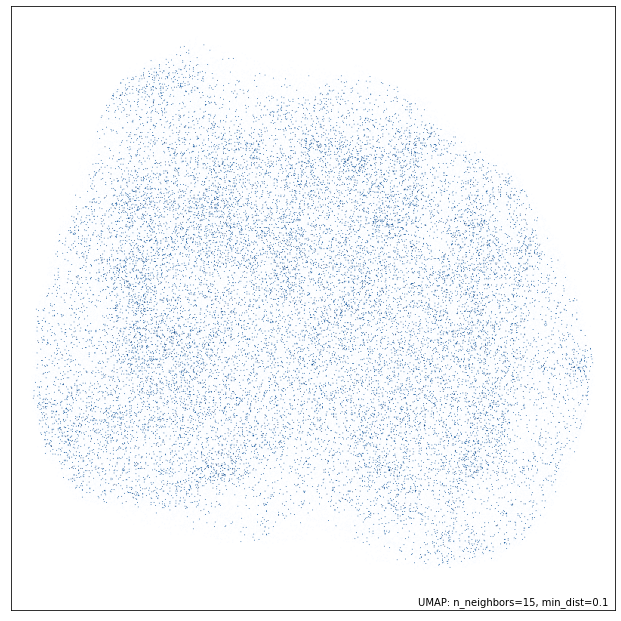

In [159]:
umap.plot.points(latents_mapping)